### Load libs

In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import tensorflow as tf



from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers
import seaborn as sns
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import array_to_img, img_to_array, load_img
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, ZeroPadding2D, Flatten, Activation
from keras.models import Sequential, Model

import os
import cv2


%matplotlib inline

sns.set(style='whitegrid', palette='muted', font_scale=1.5)

### Helpers. Params. Preprocesing


In [28]:
def fixed_generator(generator):
    for batch in generator:
        yield (batch, batch)   

In [35]:
def mse(imageA, imageB):
    err = np.sum((imageA.astype("float") - imageB.astype("float")) ** 2)
    err /= float(imageA.shape[0] * imageA.shape[1])
    return err

In [55]:
#Test any image
def IsImageHasAnomaly(autoencoder, filePath,threshold):  
    im = cv2.resize(cv2.imread(filePath), (420, 420))
    im = im * 1./255
    datas = np.zeros((1,  420, 420, 3))
    validation_image[0, :, :, :] = im;   
    predicted_image = autoencoder.predict(validation_image)
    _mse = mse(predicted_image[0], validation_image[0]) 
    print('_mse: {}'.format(_mse))
    return _mse  > threshold

In [17]:
img_width, img_height = 420, 420

batch_size = 32

nb_validation_samples=0
nb_train_samples=0

nb_epoch=20

initial_image_dir='images\\docs'
train_data_dir = initial_image_dir + '\\train'
validation_data_dir = initial_image_dir + '\\valid'

#### Generator for images to complete dataset
Generator is used for extending the image dataset by image transformation

In [18]:
datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

#### New image generation flow

In [26]:
image_list = os.listdir(initial_image_dir) #initial path to images

inital_image_count=0
for img in image_list:   
    img_path= initial_image_dir + '\\' + img
    if not os.path.isfile(img_path):
        continue
       
    inital_image_count += 1  
    
    img = load_img(img_path)  # this is a PIL image
    x = img_to_array(img)  # this is a Numpy array with shape (3, 150, 150)
    x = x.reshape((1,) + x.shape)  # this is a Numpy array with shape (1, 3, 150, 150)
    
    train_save_to = train_data_dir + '\\correct_samples'
    if not os.path.exists(train_save_to):
        os.makedirs(train_save_to)
    
    valid_save_to = validation_data_dir + '\\correct_samples'
    if not os.path.exists(valid_save_to):
        os.makedirs(valid_save_to)
    
    print("generate additional images for train in: " + train_save_to)
    
    i = 0
    for batch in datagen.flow(x, batch_size=5, save_to_dir = train_save_to, save_prefix='sample', save_format='jpeg'):
        i += 1
        if i > 20:
            break  # otherwise the generator would loop indefinitely

    train_size=0            
    for t in os.listdir(train_save_to):
        if os.path.isfile(train_save_to +"\\" + t):
            train_size += 1 
            
            
    print("generate additional images for validation in: " + valid_save_to)
    ii=0
    for batch in datagen.flow(x, batch_size=1, save_to_dir=valid_save_to, save_prefix='doc', save_format='jpeg'):
        ii += 1
        if ii > 4:
            break  # otherwise the generator would loop indefinitely
            
    validation_size=0            
    for v in os.listdir(valid_save_to):
        if os.path.isfile(valid_save_to+"\\" +v):
            validation_size += 1 
            
print("-------------------------------------------")
print("Initial image count: {} ".format(inital_image_count))
print("Train image count: {} ".format(train_size))
print("Validation image count: {} ".format(validation_size))

generate additional images for train in: images\docs\train\correct_samples
generate additional images for validation in: images\docs\valid\correct_samples
generate additional images for train in: images\docs\train\correct_samples
generate additional images for validation in: images\docs\valid\correct_samples
generate additional images for train in: images\docs\train\correct_samples
generate additional images for validation in: images\docs\valid\correct_samples
generate additional images for train in: images\docs\train\correct_samples
generate additional images for validation in: images\docs\valid\correct_samples
generate additional images for train in: images\docs\train\correct_samples
generate additional images for validation in: images\docs\valid\correct_samples
generate additional images for train in: images\docs\train\correct_samples
generate additional images for validation in: images\docs\valid\correct_samples
generate additional images for train in: images\docs\train\correct_sam

### Exract data for train and test

In [33]:
# this is the augmentation configuration we will use for training
# only rescaling
train_datagen = ImageDataGenerator(rescale=1./255)

# this is the augmentation configuration we will use for testing:
# only rescaling
test_datagen = ImageDataGenerator(rescale=1./255)

# this is a generator that will read pictures
train_generator = train_datagen.flow_from_directory(
        train_data_dir,  # this is the target directory
        target_size=(img_width, img_height),  
        batch_size=batch_size,
        color_mode='rgb', 
        class_mode=None)  

nb_train_samples=train_generator.samples
# this is a similar generator, for validation data
validation_generator = test_datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        color_mode='rgb', 
        class_mode=None)

nb_validation_samples=validation_generator.samples

Found 607 images belonging to 1 classes.
Found 150 images belonging to 1 classes.


### Build Simplest Model

In [39]:
input_img = Input(batch_shape=(None, img_width, img_width, 3))

x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# at this point the representation is (4, 4, 8) i.e. 128-dimensional

x = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)

autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 420, 420, 3)       0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 420, 420, 16)      448       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 210, 210, 16)      0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 210, 210, 8)       1160      
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 105, 105, 8)       0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 105, 105, 8)       584       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 53, 53, 8)         0         
__________

### Train our network

In [40]:
autoencoder.fit_generator(
        fixed_generator(train_generator),
        steps_per_epoch=nb_train_samples // batch_size,
        epochs=nb_epoch,
        validation_data=fixed_generator(validation_generator),
        validation_steps=nb_validation_samples // batch_size)

Epoch 1/20
18/18 [==============================] - 291s 16s/step - loss: 0.4760 - val_loss: 0.3653
Epoch 2/20
18/18 [==============================] - 280s 16s/step - loss: 0.3578 - val_loss: 0.3466
Epoch 3/20
18/18 [==============================] - 280s 16s/step - loss: 0.3482 - val_loss: 0.3541
Epoch 4/20
18/18 [==============================] - 281s 16s/step - loss: 0.3449 - val_loss: 0.3652
Epoch 5/20
18/18 [==============================] - 281s 16s/step - loss: 0.3427 - val_loss: 0.3360
Epoch 6/20
18/18 [==============================] - 280s 16s/step - loss: 0.3428 - val_loss: 0.3417
Epoch 7/20
18/18 [==============================] - 283s 16s/step - loss: 0.3473 - val_loss: 0.3420
Epoch 8/20
18/18 [==============================] - 280s 16s/step - loss: 0.3432 - val_loss: 0.3374
Epoch 9/20
18/18 [==============================] - 282s 16s/step - loss: 0.3292 - val_loss: 0.3360
Epoch 10/20
18/18 [==============================] - 280s 16s/step - loss: 0.3348 - val_loss: 0.3695

### Save weights

In [41]:
autoencoder.save_weights('anomaly-detection.h5')

### Load weights

In [42]:
autoencoder.load_weights('anomaly-detection.h5');

### Test encoder and visualize result

In [ ]:
img = next(validation_generator)[:7] # Get rendom image

dec = autoencoder.predict(img) # Decoded image
img = img[0]
dec = dec[0]
img = (img*255).astype('uint8')
dec = (dec*255).astype('uint8')

plt.imshow(np.hstack((img, dec)))
plt.title('Original and reconstructed images')
plt.show()

## Visual result

Example of using mse

In [44]:
#collect all mse-s
all_mses=[]
step=1;
for validation_image in validation_generator:   
    if step>nb_validation_samples:
        break;
        
    print(step, sep=' ', end='>', flush=True)       
    predicted_image = autoencoder.predict(validation_image)
    mse_value= mse(predicted_image[0], validation_image[0])
    all_mses.append(mse_value)
    step=step+1


1>2>3>4>5>6>7>8>9>10>11>12>13>14>15>16>17>18>19>20>21>22>23>24>25>26>27>28>29>30>31>32>33>34>35>36>37>38>39>40>41>42>43>44>45>46>47>48>49>50>51>52>53>54>55>56>57>58>59>60>61>62>63>64>65>66>67>68>69>70>71>72>73>74>75>76>77>78>79>80>81>82>83>84>85>86>87>88>89>90>91>92>93>94>95>96>97>98>99>100>101>102>103>104>105>106>107>108>109>110>111>112>113>114>115>116>117>118>119>120>121>122>123>124>125>126>127>128>129>130>131>132>133>134>135>136>137>138>139>140>141>142>143>144>145>146>147>148>149>150>

In [46]:
error_df = pd.DataFrame({'reconstruction_error':all_mses})
error_df.describe()

,reconstruction_error
count,150.000000
mean,0.100630
std,0.056851
min,0.041283
25%,0.066063
50%,0.082397
75%,0.107733
max,0.270635


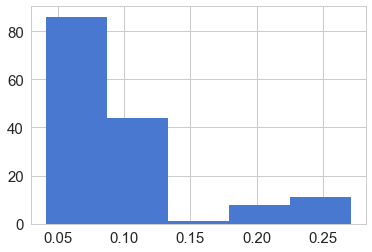

In [48]:
fig = plt.figure()
ax = fig.add_subplot(111)

_ = ax.hist(error_df.reconstruction_error.values, bins=5)

 Selecting th

In [57]:
# base on visulization lets say that everething that more then 0.14 likelihood anomaly
# set threshold manually
threshold=0.14

In [65]:
IsImageHasAnomaly(autoencoder, 'original.jpg',threshold)

_mse: 0.0670472955415333


False